In [1]:
import tensorflow as tf
import numpy as np
import random
from collections import deque
import os
import joblib # Make sure joblib is imported if not already
import pandas as pd # Make sure pandas is imported
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [2]:
# ─── Replay Buffer ─────────────────────────────────────────────────────────
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        # Ensure consistent types, especially for TF Function
        self.buffer.append((np.array(state, dtype=np.float32),
                            np.array(action, dtype=np.int32),
                            np.array(reward, dtype=np.float32),
                            np.array(next_state, dtype=np.float32),
                            np.array(done, dtype=np.float32))) # Use float for done

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        # Ensure actions and dones have the correct shape for TF ops
        return s, a.reshape(-1), r.reshape(-1, 1), s2, d.reshape(-1, 1)


    def __len__(self):
        return len(self.buffer)

In [3]:
class DuelingDQN(tf.keras.Model):
    def __init__(self, input_dim, n_actions, hidden_units=[128, 64], dropout_rate=0.25): # Made hidden units configurable
        super().__init__()
        # Define layers dynamically based on hidden_units list
        self.hidden_layers = []
        for units in hidden_units:
             self.hidden_layers.append(tf.keras.layers.Dense(units, activation='relu'))
        # self.fc1 = tf.keras.layers.Dense(hidden_units, activation='relu') # Original simple version
        self.drop = tf.keras.layers.Dropout(dropout_rate)
        # advantage stream
        self.adv = tf.keras.layers.Dense(n_actions, name="advantage") # Added names
        # value stream
        self.val = tf.keras.layers.Dense(1, name="value") # Added names

    def call(self, x):
        # Pass through hidden layers
        for layer in self.hidden_layers:
             x = layer(x)
        # x = self.fc1(x) # Original simple version
        x = self.drop(x)
        adv = self.adv(x)
        val = self.val(x)
        # dueling aggregation: Q(s,a) = V(s) + (A(s,a) - mean A(s,·))
        # Ensure correct reduction mean calculation
        mean_adv = tf.reduce_mean(adv, axis=1, keepdims=True)
        q_values = val + (adv - mean_adv)
        return q_values

In [4]:
class Agent:
    def __init__(self, state_dim, n_actions, rewards_lab, minority_classes, config): # Added config
                 # gamma=0.99, lr=1e-3, batch_size=64, # Moved to config
                 # eps_start=1.0, eps_end=0.01, eps_decay_steps=10000,
                 # buffer_capacity=50000, target_update_freq=500,
                 # hidden_units=[128, 64], dropout_rate=0.25): # Moved to config

        self.config = config # Store config
        self.n_actions = n_actions

        # networks
        self.net = DuelingDQN(state_dim, n_actions, config.hidden_units, config.dropout_rate)
        self.target = DuelingDQN(state_dim, n_actions, config.hidden_units, config.dropout_rate)
        # Ensure networks are built before setting weights
        # A dummy call can build the network
        dummy_input = tf.random.normal((1, state_dim))
        _ = self.net(dummy_input)
        _ = self.target(dummy_input)
        self.target.set_weights(self.net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(config.lr)
        self.buffer = ReplayBuffer(config.buffer_capacity)

        # RL params
        self.gamma = config.gamma
        self.batch_size = config.batch_size

        # ε-greedy
        self.eps_start, self.eps_end, self.eps_decay = config.eps_start, config.eps_end, config.eps_decay_steps
        self.epsilon = self.eps_start
        self.train_step = 0 # Tracks training updates

        # reward shaping
        self.rewards_lab = rewards_lab # dict: label→reward magnitude
        self.minority = set(minority_classes) # e.g. {1}

        # target net updates
        self.target_update_freq = config.target_update_freq # Frequency for soft update
        self.target_soft_update_rate = config.target_soft_update_rate # Tau for soft update


    def select_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
             # Return random action index (0 or 1 for binary classification)
            return np.random.randint(0, self.n_actions)
        # Need to add batch dimension if state is single sample
        if len(state.shape) == 1:
            state = state[np.newaxis, :]
        # Ensure state is float32 for TensorFlow model
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        q_values = self.net(state_tensor, training=False) # Use training=False for inference
        return tf.argmax(q_values, axis=1).numpy()[0] # Get the index


    def get_reward(self, label, action):
        # Ensure label and action are integers
        label = int(label)
        action = int(action)
        reward_magnitude = self.rewards_lab.get(label, 0) # Default to 0 if label not in dict

        r = reward_magnitude if action == label else -reward_magnitude
        # Early termination if minority class is misclassified
        done = bool((label in self.minority) and (action != label))
        return r, done

    def store_transition(self, s, a, r, s2, done):
        self.buffer.add(s, a, r, s2, done) # Buffer handles type conversion now

    def update_epsilon(self, current_step): # Pass current step for decay calculation
        frac = min(current_step / self.eps_decay, 1.0)
        self.epsilon = self.eps_start + frac*(self.eps_end - self.eps_start)
        # Or alternatively, linear decay:
        # self.epsilon = max(self.eps_end, self.eps_start - (self.eps_start - self.eps_end) * (current_step / self.eps_decay))


    @tf.function
    def _train_on_batch_tf(self, states, actions, rewards, next_states, dones):
        # Ensure types match what tf.function expects
        actions = tf.cast(actions, tf.int32)
        rewards = tf.cast(rewards, tf.float32)
        dones = tf.cast(dones, tf.float32)

        # Compute target Q (Double DQN logic)
        q_next_main = self.net(next_states) # Q values from main net for next state
        next_actions = tf.argmax(q_next_main, axis=1, output_type=tf.int32) # Best actions according to main net

        q_next_target = self.target(next_states) # Q values from target net for next state

        # Create indices for gather_nd [[batch_idx_0, action_idx_0], [batch_idx_1, action_idx_1], ...]
        indices = tf.stack([tf.range(tf.shape(actions)[0]), next_actions], axis=1)

        # Gather the Q-values from target network corresponding to the best actions selected by main network
        target_q_values = tf.gather_nd(q_next_target, indices)
        target_q_values = tf.expand_dims(target_q_values, axis=1) # Ensure shape is (batch_size, 1)

        # Calculate TD target: y = r + gamma * Q_target(s', argmax_a' Q_main(s', a')) * (1 - done)
        y = rewards + (1.0 - dones) * self.gamma * target_q_values

        with tf.GradientTape() as tape:
            # Get Q-values from main network for the *original* state-action pairs
            q_main = self.net(states)
            # Indices for the actions actually taken
            action_indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
            # Q-value for the action taken
            q_a = tf.gather_nd(q_main, action_indices)
            q_a = tf.expand_dims(q_a, axis=1) # Ensure shape is (batch_size, 1)

            # Calculate loss (e.g., Huber loss)
            loss = tf.keras.losses.Huber()(y, q_a)

        # Compute and apply gradients
        grads = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))
        return loss

    def update_if_ready(self):
        """Samples a batch and performs a training step if buffer is ready."""
        if len(self.buffer) < self.batch_size:
            return None # Not enough samples yet

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # Convert numpy arrays to TensorFlow tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32) # Actions are indices
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        loss = self._train_on_batch_tf(states, actions, rewards, next_states, dones)
        return loss.numpy()


    def update_target_network(self):
        """Soft update of the target network."""
        tau = self.config.target_soft_update_rate
        main_weights = self.net.get_weights()
        target_weights = self.target.get_weights()
        new_target_weights = []
        for main_w, target_w in zip(main_weights, target_weights):
            new_w = (1.0 - tau) * target_w + tau * main_w
            new_target_weights.append(new_w)
        self.target.set_weights(new_target_weights)


    def run_evaluation(self, X_eval, y_eval):
        """ Runs evaluation on a given dataset split. """
        preds = []
        q_vals_list = [] # Optional: to get raw Q values
        for i in range(len(X_eval)):
            state = X_eval[i]
            action = self.select_action(state, training=False) # Use greedy policy for eval
            preds.append(action)
            # q_vals = self.net(state[np.newaxis, :], training=False).numpy()[0]
            # q_vals_list.append(q_vals) # Store Q-values if needed

        # Calculate metrics
        acc = accuracy_score(y_eval, preds)
        recall = recall_score(y_eval, preds, pos_label=1) # Recall for minority class (stroke=1)
        specificity = recall_score(y_eval, preds, pos_label=0) # Specificity (Recall for majority class)
        precision = precision_score(y_eval, preds, pos_label=1, zero_division=0)
        f1 = f1_score(y_eval, preds, pos_label=1, zero_division=0)
        gmean = np.sqrt(recall * specificity)
        # For AUC, you might need predicted probabilities if your network outputs them,
        # or use the Q-values if appropriate for your setup.
        # Example using Q-value difference (can be noisy):
        # try:
        #     q_diffs = [q[1] - q[0] for q in q_vals_list] # Difference Q(s, 1) - Q(s, 0)
        #     auc = roc_auc_score(y_eval, q_diffs)
        # except ValueError: # Handle case where only one class is predicted
        #     auc = 0.5
        auc = 0.5 # Placeholder - AUC calculation needs refinement

        print(f" Acc: {acc:.4f}, Rec: {recall:.4f}, Spec: {specificity:.4f}, Prec: {precision:.4f}, F1: {f1:.4f}, G-Mean: {gmean:.4f}") # Removed AUC for now
        return {'accuracy': acc, 'recall': recall, 'specificity': specificity, 'precision': precision, 'f1_score': f1, 'g_mean': gmean} # 'auc_roc': auc}


    def save(self, path, step):
        model_dir = os.path.join(path, f"step_{step}")
        os.makedirs(model_dir, exist_ok=True)
        self.net.save_weights(os.path.join(model_dir, 'qimb_weights.weights.h5')) # Use .ckpt for TF weights
        self.target.save_weights(os.path.join(model_dir, 'qimb_weights.weights.h5'))
        print(f"Model saved at step {step} to {model_dir}")

    def load(self, path, step):
      model_dir = os.path.join(path, f"step_{step}")
      if os.path.exists(os.path.join(model_dir, 'qimb_weights.ckpt.index')): # Check for index file
          self.net.load_weights(os.path.join(model_dir, 'qimb_weights.weights.h5'))
          self.target.load_weights(os.path.join(model_dir, 'qimb_weights.weights.h5'))
          print(f"Model loaded from step {step} from {model_dir}")
      else:
          print(f"No checkpoint found at {model_dir}")

In [5]:
from types import SimpleNamespace # To create a config object easily

# --- Configuration ---
# Create a config object (replace with your hyperparameter choices)
config = SimpleNamespace(
    # Training Params
    training_steps=100000, # Total training updates (adjust as needed)
    max_episode_steps = 1000, # Max steps per "episode" if not terminating early

    # DRL Params
    gamma=0.99,
    lr=0.00025, # Learning rate (tune this)
    batch_size=64,
    buffer_capacity=50000,

    # Epsilon Greedy Params
    eps_start=1.0,
    eps_end=0.01,
    eps_decay_steps=50000, # Steps over which epsilon decays (tune this)

    # Network Params
    hidden_units=[128, 64], # Example architecture (tune this)
    dropout_rate=0.25,

    # Target Network Update Params
    target_update_freq=500, # How often to update target net (steps)
    target_soft_update_rate=0.01, # Tau for soft updates (if using soft updates)

    # Reward Params
    minority_classes={1}, # Stroke is label 1

    # Evaluation/Saving Params
    eval_freq=5000, # How often to evaluate on validation set
    save_freq=20000, # How often to save model checkpoints
    model_save_path='./baseline_model_checkpoints/'
)

In [6]:
(X_train_np, y_train_np) = joblib.load('train_data.pkl')
(X_val_np, y_val_np) = joblib.load('val_data.pkl')
(X_test_np, y_test_np) = joblib.load('test_data.pkl')

if isinstance(X_train_np, pd.DataFrame):
    X_train_np = X_train_np.values
    X_val_np = X_val_np.values
    X_test_np = X_test_np.values
if isinstance(y_train_np, pd.Series):
    y_train_np = y_train_np.values
    y_val_np = y_val_np.values
    y_test_np = y_test_np.values

print(f"Data loaded: Train={X_train_np.shape}, Val={X_val_np.shape}, Test={X_test_np.shape}")

Data loaded: Train=(3576, 15), Val=(766, 15), Test=(767, 15)


In [7]:
state_dim = X_train_np.shape[1]
n_actions = 2 # Predict 0 or 1

# Calculate imbalance ratio (majority/minority) for reward
counts = np.bincount(y_train_np.astype(int))
minority_count = counts[1]
majority_count = counts[0]
imbalance_ratio_rho = minority_count / majority_count # As per Lin et al. definition
print(f"Minority Count: {minority_count}, Majority Count: {majority_count}, Rho: {imbalance_ratio_rho:.4f}")

# Define rewards (using rho as in Lin et al. / Yang et al. reward structure)
# Reward magnitude is 1 for minority, rho for majority
rewards_lab = {
    0: imbalance_ratio_rho, # Reward/Penalty magnitude for majority class (No Stroke)
    1: 1.0                  # Reward/Penalty magnitude for minority class (Stroke)
}
print(f"Rewards Dictionary: {rewards_lab}")

Minority Count: 174, Majority Count: 3402, Rho: 0.0511
Rewards Dictionary: {0: 0.05114638447971781, 1: 1.0}


In [8]:
# Instantiate Agent
agent = Agent(
    state_dim=state_dim,
    n_actions=n_actions,
    rewards_lab=rewards_lab,
    minority_classes=config.minority_classes,
    config=config # Pass the whole config object
)

In [9]:
import time
# --- Training Loop ---
print(f"\nStarting Training for {config.training_steps} steps...")
start_time = time.time()

# Lists to store metrics for plotting
step_losses = []          # Loss after each update step
step_rewards = []         # Reward received at each interaction step
epsilon_history = []      # Epsilon value at each interaction step
validation_history = []   # Dict of metrics after each evaluation interval
best_val_gmean = -1       # Track best validation G-Mean for saving best model
training_steps_done = 0   # Counter for gradient updates performed
interaction_steps = 0     # Counter for environment interactions (s,a,r,s')

# Use an index to cycle through training data (optional, random sampling is also common)
current_train_idx = 0
num_train_samples = len(X_train_np)

# We control training by the number of gradient updates (training_steps_done)
while training_steps_done < config.training_steps:

    # sample current state and label
    idx = np.random.randint(num_train_samples) # Randomly sample index
    s = X_train_np[idx]
    y = y_train_np[idx]

    # select action
    a = agent.select_action(s, training=True)

    # get reward and done flag
    r, done = agent.get_reward(int(y), int(a))
    step_rewards.append(r) # Log reward

    # sample next state (independent random sample in this formulation)
    idx2 = np.random.randint(num_train_samples)
    s2 = X_train_np[idx2]

    # store transition
    agent.store_transition(s, a, r, s2, done)

    # Store epsilon before potentially updating it
    epsilon_history.append({'step': interaction_steps, 'epsilon': agent.epsilon})

    # Increment interaction counter
    interaction_steps += 1

    # --- Perform Gradient Update if Buffer Ready ---
    loss = agent.update_if_ready() # Tries to sample batch_size and train
    if loss is not None:
        step_losses.append(loss)    # Log loss only when an update happens
        training_steps_done += 1    # Increment step counter based on updates
        agent.train_step = training_steps_done # Update agent's internal step counter if it uses it

        # --- Soft-update target network periodically ---
        if training_steps_done % config.target_update_freq == 0:
             agent.update_target_network()

        # --- Decay epsilon based on training steps done ---
        agent.update_epsilon(training_steps_done)

        # --- Periodic evaluation and saving based on training steps done ---
        if training_steps_done % config.eval_freq == 0:
            eval_start_time = time.time()
            print(f"\n--- Step {training_steps_done} ({interaction_steps} interactions) ---")
            print(f"Epsilon: {agent.epsilon:.4f}")
            print("Running Validation Set Eval:")
            val_metrics = agent.run_evaluation(X_val_np, y_val_np)
            val_metrics['step'] = training_steps_done # Add step to metrics dict
            validation_history.append(val_metrics)
            print(f"Validation Took: {time.time() - eval_start_time:.2f}s")

            # Save model if it's the best one based on validation G-Mean so far
            current_val_gmean = val_metrics.get('g_mean', -1)
            if current_val_gmean > best_val_gmean:
                print(f"New best validation G-Mean: {current_val_gmean:.4f} (previous: {best_val_gmean:.4f}). Saving best model...")
                best_val_gmean = current_val_gmean
                agent.save(config.model_save_path, 'best') # Save as 'best'

        if training_steps_done % config.save_freq == 0:
             agent.save(config.model_save_path, training_steps_done) # Periodic save

    # Handle early termination if 'done' is True (minority misclassification)
    # For this setup, we might just continue sampling rather than resetting an 'episode'
    # If you wanted episodic structure, you'd reset state 's' here if done=True

# --- End of Training Loop ---
training_duration = time.time() - start_time
print(f"\nTraining Finished in {training_duration:.2f} seconds.")

# Save final model
agent.save(config.model_save_path, 'final')

# Save training history/metrics
try:
    loss_df = pd.DataFrame({'step': range(len(step_losses)), 'loss': step_losses})
    loss_df.to_csv(os.path.join(config.results_save_path, 'step_losses.csv'), index=False)

    rewards_df = pd.DataFrame({'step': range(len(step_rewards)), 'reward': step_rewards})
    rewards_df.to_csv(os.path.join(config.results_save_path, 'step_rewards.csv'), index=False)

    epsilon_df = pd.DataFrame(epsilon_history)
    epsilon_df.to_csv(os.path.join(config.results_save_path, 'epsilon_history.csv'), index=False)

    if validation_history:
        val_history_df = pd.DataFrame(validation_history)
        val_history_df.to_csv(os.path.join(config.results_save_path, 'validation_history.csv'), index=False)
    print("Training metrics saved.")
except Exception as e:
    print(f"Error saving training metrics: {e}")




Starting Training for 100000 steps...

--- Step 5000 (5063 interactions) ---
Epsilon: 0.9010
Running Validation Set Eval:
 Acc: 0.6762, Rec: 0.6216, Spec: 0.6790, Prec: 0.0895, F1: 0.1565, G-Mean: 0.6497
Validation Took: 4.74s
New best validation G-Mean: 0.6497 (previous: -1.0000). Saving best model...
Model saved at step best to ./baseline_model_checkpoints/step_best

--- Step 10000 (10063 interactions) ---
Epsilon: 0.8020
Running Validation Set Eval:
 Acc: 0.6214, Rec: 0.7297, Spec: 0.6159, Prec: 0.0879, F1: 0.1570, G-Mean: 0.6704
Validation Took: 5.10s
New best validation G-Mean: 0.6704 (previous: 0.6497). Saving best model...
Model saved at step best to ./baseline_model_checkpoints/step_best

--- Step 15000 (15063 interactions) ---
Epsilon: 0.7030
Running Validation Set Eval:
 Acc: 0.6123, Rec: 0.7297, Spec: 0.6063, Prec: 0.0860, F1: 0.1538, G-Mean: 0.6652
Validation Took: 4.69s

--- Step 20000 (20063 interactions) ---
Epsilon: 0.6040
Running Validation Set Eval:
 Acc: 0.7102, Rec

In [10]:
# # --- Final Evaluation ---
# print("\n--- Final Test Set Evaluation ---")
# # Optional: Load best model based on validation history before final eval
# # agent.load(config.model_save_path, best_step) # Need logic to find best_step
# test_metrics = agent.run_evaluation(X_test_np, y_test_np)


--- Final Test Set Evaluation ---
 Acc: 0.7288, Rec: 0.3684, Spec: 0.7476, Prec: 0.0707, F1: 0.1186, G-Mean: 0.5248


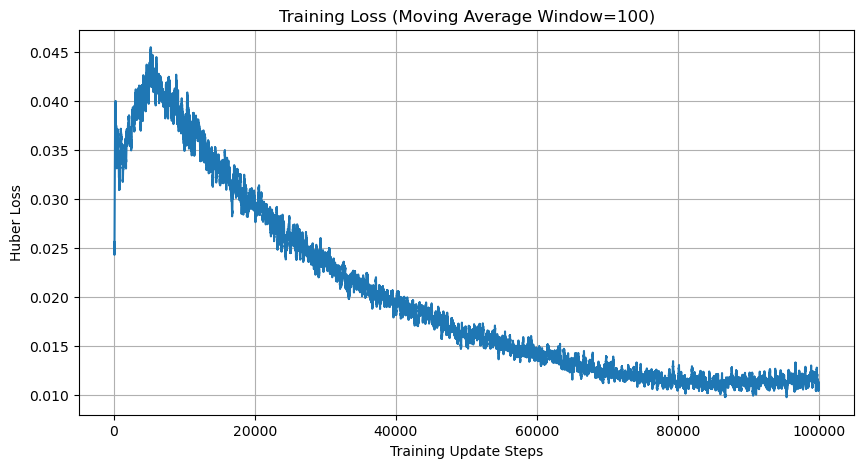

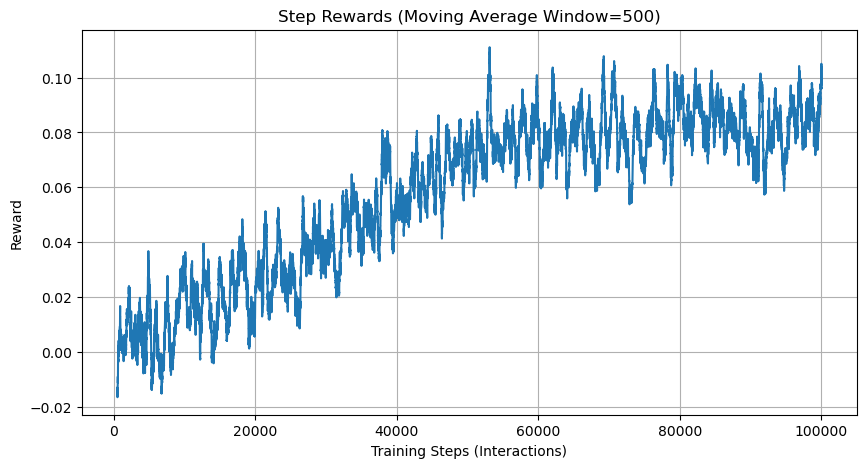

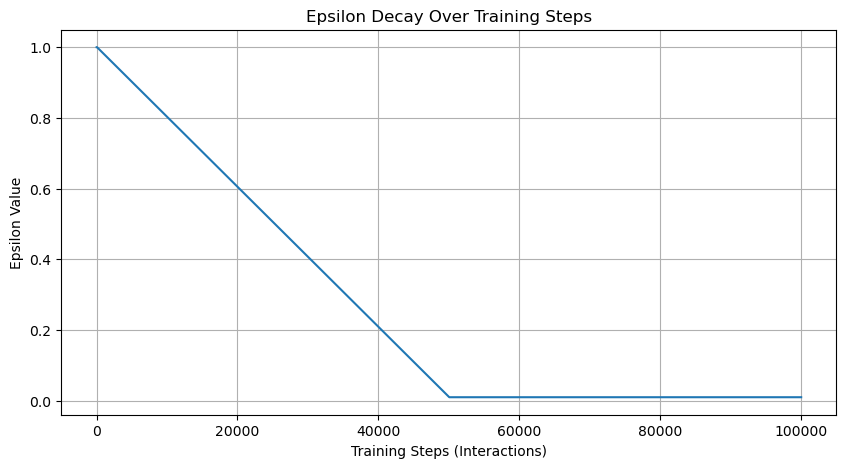

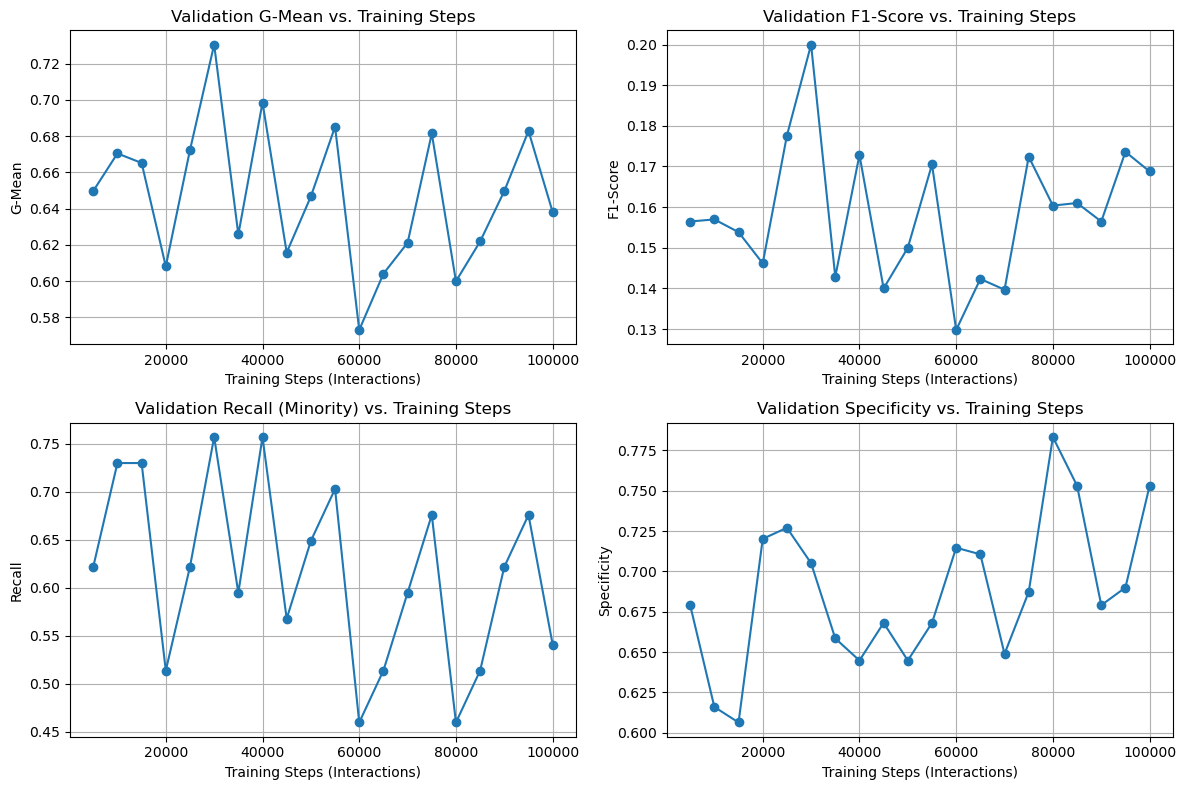

In [12]:
# --- STEP 8: Plot Training Diagnostics ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Helper function for moving average
def moving_average(data, window_size):
    if len(data) < window_size:
        return np.array([]) # Return empty if not enough data for window
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 1. Plot Training Loss (Smoothed)
plt.figure(figsize=(10, 5))
loss_ma_window = 100 # Adjust window size as needed
smoothed_losses = moving_average(step_losses, loss_ma_window)
if smoothed_losses.any(): # Check if array is not empty
     plt.plot(range(loss_ma_window -1, len(step_losses)), smoothed_losses)
     plt.title(f'Training Loss (Moving Average Window={loss_ma_window})')
     plt.xlabel('Training Update Steps')
     plt.ylabel('Huber Loss')
     plt.grid(True)
     plt.show()
else:
     print("Not enough loss data points to plot moving average.")


# 2. Plot Step Rewards (Smoothed)
plt.figure(figsize=(10, 5))
reward_ma_window = 500 # Adjust window size
smoothed_rewards = moving_average(step_rewards, reward_ma_window)
if smoothed_rewards.any():
    # Adjust x-axis to match the steps where moving average is valid
    reward_steps = np.arange(reward_ma_window - 1, len(step_rewards))
    plt.plot(reward_steps, smoothed_rewards)
    plt.title(f'Step Rewards (Moving Average Window={reward_ma_window})')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()
else:
     print("Not enough reward data points to plot moving average.")


# 3. Plot Epsilon Decay
if epsilon_history:
    eps_df = pd.DataFrame(epsilon_history)
    plt.figure(figsize=(10, 5))
    plt.plot(eps_df['step'], eps_df['epsilon'])
    plt.title('Epsilon Decay Over Training Steps')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('Epsilon Value')
    plt.grid(True)
    plt.show()
else:
    print("No epsilon history recorded.")


# 4. Plot Validation Metrics Over Time
if validation_history:
    val_df = pd.DataFrame(validation_history)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(val_df['step'], val_df['g_mean'], marker='o', linestyle='-')
    plt.title('Validation G-Mean vs. Training Steps')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('G-Mean')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(val_df['step'], val_df['f1_score'], marker='o', linestyle='-')
    plt.title('Validation F1-Score vs. Training Steps')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('F1-Score')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(val_df['step'], val_df['recall'], marker='o', linestyle='-')
    plt.title('Validation Recall (Minority) vs. Training Steps')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('Recall')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(val_df['step'], val_df['specificity'], marker='o', linestyle='-')
    plt.title('Validation Specificity vs. Training Steps')
    plt.xlabel('Training Steps (Interactions)')
    plt.ylabel('Specificity')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No validation history recorded.")



In [ ]:
# --- To Visualize Variability (Requires running the training multiple times) ---
# Assuming you have run the training loop multiple times (e.g., 5 seeds)
# and stored the validation_history DataFrames for each run in a list called `all_runs_val_history`

# Example using Seaborn for G-Mean with standard deviation shading:
# import seaborn as sns
#
# if 'all_runs_val_history' in locals() and all_runs_val_history: # Check if list exists and is not empty
#     # Combine all dataframes into one, adding a 'run' column
#     combined_val_df = pd.concat(all_runs_val_history, keys=range(len(all_runs_val_history)), names=['run', 'original_index'])
#     combined_val_df = combined_val_df.reset_index()
#
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=combined_val_df, x='step', y='g_mean', errorbar='sd') # Use errorbar='sd' for std dev shading
#     plt.title('Validation G-Mean Across Multiple Runs (Mean ± Std Dev)')
#     plt.xlabel('Training Steps (Interactions)')
#     plt.ylabel('G-Mean')
#     plt.grid(True)
#     plt.show()
# else:
#     print("Run the experiment multiple times and store results in 'all_runs_val_history' list to plot variability.")